# **Imports**

In [120]:
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
import prepare
import acquire
import env
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
np.set_printoptions(threshold= np.inf)

%matplotlib inline

# Questions to answer:

1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?
3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?
5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?
6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?
7. Which lessons are least accessed?
8. Anything else I should be aware of?

In [121]:
df = acquire.get_cohort_curr_data()
df = prepare.initial_prep(df)

In [122]:
df.head()

,endpoint,user_id,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,program_id,program
dt,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java


# 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [123]:
#creating new feature which gives name instead of number.
df['program'] = df.program_id.replace([1,2,3,4], ['full_stack_php', 'java', 'data_science', 'front_end_program'])

In [124]:
# lesson which atracts most attention for program
fsp = pd.DataFrame(df[df.program_id == 1])
fsp

,endpoint,user_id,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,program_id,program
dt,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
2018-01-26 10:14:47,/,11,1.0,97.105.19.61,1,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-10 00:20:55,content/javascript/conditionals.html,51,13.0,72.179.168.148,13,Kings,#kings,2016-05-23,2016-09-15,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
2021-04-10 00:21:15,content/javascript/loops.html,51,13.0,72.179.168.148,13,Kings,#kings,2016-05-23,2016-09-15,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
2021-04-10 00:28:10,content/javascript/javascript-with-html.html,80,14.0,136.50.29.193,14,Lassen,#lassen,2016-07-18,2016-11-10,2016-07-18 19:06:27,2016-07-18 19:06:27,1,full_stack_php


In [6]:
jv = pd.DataFrame(df[df.program_id == 2])


In [7]:
ds = pd.DataFrame(df[df.program_id == 3])


In [8]:
fep = pd.DataFrame(df[df.program_id == 4])


----

## Full Stack PHP Program

In [11]:
fsp_cohort = pd.DataFrame(fsp[fsp.endpoint != '/'].groupby('cohort')['endpoint'].value_counts())

In [12]:
fsp_cohort_list = list(fsp.cohort.value_counts().index)

In [13]:
import statistics
from statistics import mode

In [14]:
for cohort in fsp_cohort_list:
    if cohort != 'Everglades':
        max_list = []
        df_cohort = pd.DataFrame(fsp[fsp.endpoint != '/'].groupby('cohort')['endpoint'].value_counts())
        cep_df = fsp_cohort.loc[[cohort]]
        #most_frequent = list(set(fsp_cohort.loc[[cohort]])
        cep_df = cep_df.endpoint.nlargest(3)
        print('-----------------')
        print(cep_df)
        print('-----------------')
    
        
        


-----------------
cohort  endpoint    
Lassen  index.html      877
        javascript-i    233
        java-iii        224
Name: endpoint, dtype: int64
-----------------
-----------------
cohort  endpoint     
Arches  javascript-i     294
        html-css         215
        javascript-ii    204
Name: endpoint, dtype: int64
-----------------
-----------------
cohort   endpoint    
Olympic  javascript-i    128
         java-i           76
         jquery           71
Name: endpoint, dtype: int64
-----------------
-----------------
cohort  endpoint                                        
Kings   index.html                                          84
        content/laravel/intro                               83
        content/laravel/intro/application-structure.html    63
Name: endpoint, dtype: int64
-----------------
-----------------
cohort   endpoint
Hampton  java-iii    57
         appendix    55
         java-i      46
Name: endpoint, dtype: int64
-----------------
----------------

#### java-i appears to be the most frequent lesson among the cohorts in the full-stack-php program

------

## Java Program

In [15]:
jv_cohort = pd.DataFrame(jv[jv.endpoint != '/'].groupby('cohort')['endpoint'].value_counts())


In [16]:
jv_cohort_list = list(jv.cohort.value_counts().index)

In [17]:
for cohort in jv_cohort_list:
    #if cohort:
        jv_cohort = pd.DataFrame(jv[jv.endpoint != '/'].groupby('cohort')['endpoint'].value_counts())
        cep_df = jv_cohort.loc[[cohort]]
        #most_frequent = list(set(fsp_cohort.loc[[cohort]])
        cep_df = cep_df.endpoint.nlargest(3)
        print('-----------------')
        print(cep_df)
        print('-----------------')
    
        
        


-----------------
cohort  endpoint    
Staff   javascript-i    1817
        spring          1403
        java-iii        1393
Name: endpoint, dtype: int64
-----------------
-----------------
cohort  endpoint                
Ceres   search/search_index.json    1380
        javascript-i                1003
        toc                          911
Name: endpoint, dtype: int64
-----------------
-----------------
cohort  endpoint    
Zion    toc             1465
        javascript-i     897
        java-iii         753
Name: endpoint, dtype: int64
-----------------
-----------------
cohort   endpoint                
Jupiter  toc                         1866
         search/search_index.json     998
         javascript-i                 926
Name: endpoint, dtype: int64
-----------------
-----------------
cohort   endpoint                
Fortuna  toc                         1293
         search/search_index.json    1020
         java-iii                     786
Name: endpoint, dtype: int64
-

#### javascript - i appears to be the most frequent lesson among the cohorts in the java program

------

## Data Science

In [18]:
ds_cohort = pd.DataFrame(ds[ds.endpoint != '/'].groupby('cohort')['endpoint'].value_counts())

In [19]:
ds_cohort_list = list(ds.cohort.value_counts().index)

In [20]:
for cohort in ds_cohort_list:
    #if cohort != 'Everglades':

    ds_cohort = pd.DataFrame(ds[ds.endpoint != '/'].groupby('cohort')['endpoint'].value_counts())
    cep_df = ds_cohort.loc[[cohort]]
    #most_frequent = list(set(fsp_cohort.loc[[cohort]])
    cep_df = cep_df.endpoint.nlargest(3)
    print('-----------------')
    print(cep_df)
    print('-----------------')

        
        


-----------------
cohort  endpoint                                
Darden  classification/overview                     1109
        classification/scale_features_or_not.svg     943
        sql/mysql-overview                           774
Name: endpoint, dtype: int64
-----------------
-----------------
cohort  endpoint                                
Bayes   1-fundamentals/modern-data-scientist.jpg    650
        1-fundamentals/AI-ML-DL-timeline.jpg        648
        1-fundamentals/1.1-intro-to-data-science    640
Name: endpoint, dtype: int64
-----------------
-----------------
cohort  endpoint                                
Curie   6-regression/1-overview                     595
        search/search_index.json                    538
        1-fundamentals/modern-data-scientist.jpg    467
Name: endpoint, dtype: int64
-----------------
-----------------
cohort  endpoint                                                     
Easley  classification/scale_features_or_not.svg               

#### Fundamentals was the most occuring lesson among the cohorts in ds program

-----

# Front End Program

In [21]:
fep_cohort = pd.DataFrame(fep[fep.endpoint != '/'].groupby('cohort')['endpoint'].value_counts())

In [22]:
fep_cohort_list = list(fep.cohort.value_counts().index)

In [23]:
for cohort in fep_cohort_list:
    #if cohort != 'Everglades':

    fep_cohort = pd.DataFrame(fep[fep.endpoint != '/'].groupby('cohort')['endpoint'].value_counts())
    cep_df = fep_cohort.loc[[cohort]]
    #most_frequent = list(set(fsp_cohort.loc[[cohort]])
    cep_df = cep_df.endpoint.nlargest(3)
    print('-----------------')
    print(cep_df)
    print('-----------------')

        
        


-----------------
cohort  endpoint                                   
Apollo  content/html-css                               2
        content/html-css/gitbook/images/favicon.ico    1
        content/html-css/introduction.html             1
Name: endpoint, dtype: int64
-----------------


#### Content/html-css is the most occuring lesson among fep cohort

----

----

# 2.) Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

# 3.) Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

ds_users[ds_users.index < ds_users.end_date]

In [7]:
fsp = pd.DataFrame(df[df.program_id == 1])

In [8]:
jv = pd.DataFrame(df[df.program_id == 2])

In [9]:
ds = pd.DataFrame(df[df.program_id == 3])

In [10]:
fep = pd.DataFrame(df[df.program_id == 4])


# Data Science

In [32]:
ds_cohort_list = list(ds.cohort.value_counts().index)

In [31]:
ds_user_list = list(ds.user_id.value_counts().index)

In [54]:
ds = ds[ds.index <= ds.end_date]
ds = ds[ds.index > ds.start_date]

In [55]:
ep_df = pd.DataFrame(ds.endpoint.value_counts(dropna=False)/ds.endpoint.count()).reset_index().\
                rename(index=str, columns={'index': 'endpoint', 'endpoint': 'ep_proba'})

In [56]:
ds = ds.reset_index().merge(ep_df, on=['endpoint'], how='left').fillna(value=0).set_index('dt')
ds.head()

,endpoint,user_id,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,program_id,program,ep_proba
dt,,,,,,,,,,,,,,
2019-08-20 09:39:58,/,466,34.0,97.105.19.58,34,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3,data_science,0.075239
2019-08-20 09:39:59,/,467,34.0,97.105.19.58,34,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3,data_science,0.075239
2019-08-20 09:39:59,/,468,34.0,97.105.19.58,34,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3,data_science,0.075239
2019-08-20 09:40:02,/,469,34.0,97.105.19.58,34,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3,data_science,0.075239
2019-08-20 09:40:08,/,470,34.0,97.105.19.58,34,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3,data_science,0.075239


In [57]:
ep_probs = ds.groupby(['endpoint']).size().div(len(ds))

ep_given_user_id_cohort = pd.DataFrame(ds.groupby(['user_id', 'endpoint']).\
                               size().div(len(ds)).\
                               div(ep_probs, 
                                   axis=0, 
                                   level='endpoint').reset_index().rename(index=str, columns={0: 'proba_uc_given_ep'}))

In [58]:
uid_ep_count = pd.DataFrame(ds.groupby(['user_id', 'endpoint'])['cohort_id'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'cohort_id': 'id_ep_count'}))


ep_user = ep_given_user_id_cohort.merge(uid_ep_count)

In [59]:
ds = ds.reset_index().merge(ep_user, on=['user_id', 'endpoint'], how='left').fillna(value=0).set_index('dt')

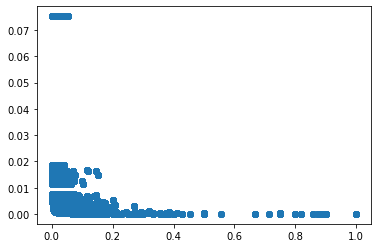

In [60]:
plt.scatter(x= ds.proba_uc_given_ep, y = ds.ep_proba)

In [76]:
df_= ds[(ds['proba_uc_given_ep'] > 0.45) & (ds['ep_proba'] < 0.02)]
df_.user_id.value_counts()

698    70
476    63
484    28
467    22
474    19
949    14
692    14
895    11
907    11
477    10
466    10
694     9
688     8
578     8
911     8
837     8
695     7
581     7
483     7
685     6
580     6
575     6
481     6
472     5
686     5
840     5
696     5
584     4
471     4
617     4
468     4
268     4
582     4
691     4
690     3
590     3
910     3
480     3
841     3
848     3
358     3
478     2
896     2
469     2
699     2
781     2
908     2
845     2
473     1
899     1
475     1
681     1
588     1
780     1
785     1
579     1
576     1
838     1
Name: user_id, dtype: int64

In [80]:
df_[df_.user_id == 698].tail(30)

,endpoint,user_id,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,program_id,program,ep_proba,proba_uc_given_ep,id_ep_count
dt,,,,,,,,,,,,,,,,
2020-11-16 12:43:15,explore,698,59.0,67.11.185.59,59,Darden,#darden,2020-07-13,2021-01-12,2020-07-13 18:32:19,2020-07-13 18:32:19,3,data_science,0.000109,0.800000,8
2020-11-16 12:43:19,prepare,698,59.0,67.11.185.59,59,Darden,#darden,2020-07-13,2021-01-12,2020-07-13 18:32:19,2020-07-13 18:32:19,3,data_science,0.000044,1.000000,4
2020-11-16 12:43:21,prepare,698,59.0,67.11.185.59,59,Darden,#darden,2020-07-13,2021-01-12,2020-07-13 18:32:19,2020-07-13 18:32:19,3,data_science,0.000044,1.000000,4
2020-11-16 12:43:23,regular-expressions,698,59.0,67.11.185.59,59,Darden,#darden,2020-07-13,2021-01-12,2020-07-13 18:32:19,2020-07-13 18:32:19,3,data_science,0.000065,1.000000,6
2020-11-19 14:56:30,model,698,59.0,67.11.185.59,59,Darden,#darden,2020-07-13,2021-01-12,2020-07-13 18:32:19,2020-07-13 18:32:19,3,data_science,0.000054,1.000000,5
2020-11-19 14:56:32,model,698,59.0,67.11.185.59,59,Darden,#darden,2020-07-13,2021-01-12,2020-07-13 18:32:19,2020-07-13 18:32:19,3,data_science,0.000054,1.000000,5
2020-11-19 14:56:33,model,698,59.0,67.11.185.59,59,Darden,#darden,2020-07-13,2021-01-12,2020-07-13 18:32:19,2020-07-13 18:32:19,3,data_science,0.000054,1.000000,5
2020-11-20 18:55:07,DataToAction_v2.jpg,698,59.0,67.10.156.23,59,Darden,#darden,2020-07-13,2021-01-12,2020-07-13 18:32:19,2020-07-13 18:32:19,3,data_science,0.000011,1.000000,1
2020-12-08 17:58:34,distributed-ml/read-jdbc,698,59.0,24.28.148.238,59,Darden,#darden,2020-07-13,2021-01-12,2020-07-13 18:32:19,2020-07-13 18:32:19,3,data_science,0.000044,0.500000,2


In [83]:
df_.endpoint.value_counts()

acquire                                       16
html-css                                      12
1-fundamentals                                 9
dataframes                                     9
3-discrete-probabilistic-methods               9
                                              ..
7-classification/svm                           1
cli/moving-files                               1
spring/extra-features/error-pages/asdfasdf     1
diagram-of-ds-pipeline-fraud-example.jpeg      1
end_to_end_clustering                          1
Name: endpoint, Length: 212, dtype: int64

--------

# Java

In [42]:
jv = pd.DataFrame(df[df.program_id == 2])
jv = jv[jv.endpoint != '/']
jv = jv[jv.index <= jv.end_date]
jv = jv[jv.index > jv.start_date]

In [43]:
ep_df = pd.DataFrame(jv.endpoint.value_counts(dropna=False)/jv.endpoint.count()).reset_index().\
                rename(index=str, columns={'index': 'endpoint', 'endpoint': 'ep_proba'})

In [44]:
jv = jv.reset_index().merge(ep_df, on=['endpoint'], how='left').fillna(value=0).set_index('dt')
jv.head()

,endpoint,user_id,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,program_id,program,ep_proba
dt,,,,,,,,,,,,,,
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java,0.010161
2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java,0.010384
2018-01-26 09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java,0.010161
2018-01-26 09:56:48,javascript-i/functions,3,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java,0.011305
2018-01-26 09:56:59,javascript-i/loops,2,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java,0.010384


In [45]:
ep_probs = jv.groupby(['endpoint']).size().div(len(jv))

ep_given_user_id_cohort = pd.DataFrame(jv.groupby(['user_id', 'endpoint']).\
                               size().div(len(jv)).\
                               div(ep_probs, 
                                   axis=0, 
                                   level='endpoint').reset_index().rename(index=str, columns={0: 'proba_uc_given_ep'}))

In [46]:
ep_given_user_id_cohort

,user_id,endpoint,proba_uc_given_ep
0,2,appendix,0.005432
1,2,appendix/angular/templating,0.019231
2,2,appendix/capstone-workbook,0.007803
3,2,appendix/documentation,0.007833
4,2,appendix/further-reading/java/intellij-tomcat-...,0.000713
...,...,...,...
74319,981,html-css,0.000743
74320,981,html-css/css-ii,0.000583
74321,981,html-css/css-ii/bootstrap-grid-system,0.003511
74322,981,html-css/css-ii/bootstrap-introduction,0.001145


In [47]:
uid_ep_count = pd.DataFrame(jv.groupby(['user_id', 'endpoint'])['cohort_id'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'cohort_id': 'id_ep_count'}))


ep_user = ep_given_user_id_cohort.merge(uid_ep_count)

In [48]:
jv = jv.reset_index().merge(ep_user, on=['user_id', 'endpoint'], how='left').fillna(value=0).set_index('dt')

In [68]:
jv.cohort.value_counts()

Jupiter       34815
Ceres         34483
Zion          32435
Fortuna       31662
Voyageurs     30639
Ganymede      28010
Apex          27548
Hyperion      27250
Betelgeuse    25271
Europa        24691
Teddy         23968
Deimos        23918
Wrangell      23058
Ulysses       22951
Kalypso       22752
Xanadu        21890
Andromeda     20344
Yosemite      18427
Luna          16132
Marco         15698
Bash          15661
Neptune        6804
Sequoia        2008
Oberon         1541
Name: cohort, dtype: int64

In [67]:
jv.head(50)

,endpoint,user_id,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,program_id,program,ep_proba,proba_uc_given_ep,id_ep_count
dt,,,,,,,,,,,,,,,,
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java,0.010161,0.004625,25
2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java,0.010384,0.004345,24
2018-01-26 09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java,0.010161,0.003330,18
2018-01-26 09:56:48,javascript-i/functions,3,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java,0.011305,0.003991,24
2018-01-26 09:56:59,javascript-i/loops,2,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java,0.010384,0.004345,24
2018-01-26 09:58:26,javascript-i/functions,4,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java,0.011305,0.001164,7
2018-01-26 09:59:22,mkdocs/search_index.json,5,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java,0.003038,0.030322,49
2018-01-26 10:00:02,javascript-i/introduction/working-with-data-ty...,6,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java,0.012151,0.003094,20
2018-01-26 10:00:39,javascript-i,6,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java,0.024859,0.003479,46


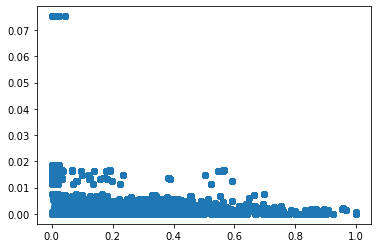

In [25]:
plt.scatter(x= jv.proba_uc_given_ep, y = jv.ep_proba)

In [73]:
jv_= jv[(jv['proba_uc_given_ep'] > 0.5) & ((jv['ep_proba'] < 0.01))]

In [81]:
jv_.endpoint.value_counts()

javascript-i/manipulating                                                   22
extra-challenges/mysql/mysql-extra-exercises                                21
appendix/further-reading/java                                               16
spring/form-model-binding                                                   16
fundamentals/controllers                                                    15
                                                                            ..
javascript-/introducion/working-with-dat-types-operators-and-variables       1
content/jquery/simple-simon/gitbook/images/favicon.ico                       1
content/php_i/intro-to-operators/assignment-operators.html                   1
content/php_i/types-and-variables-ii/objects-other-types-and-review.html     1
strings                                                                      1
Name: endpoint, Length: 328, dtype: int64

In [74]:
jv_[jv_.cohort == 'Andromeda'].head(50)

,endpoint,user_id,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,program_id,program,ep_proba,proba_uc_given_ep,id_ep_count
dt,,,,,,,,,,,,,,,,
2019-03-19 09:46:34,htmle-css/elements,385,31.0,97.105.19.58,31,Andromeda,#andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,2,java,0.000002,1.000000,1
2019-03-19 09:49:30,html,387,31.0,97.105.19.58,31,Andromeda,#andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,2,java,0.000002,1.000000,1
2019-03-19 09:49:37,html-css/elecments,373,31.0,97.105.19.58,31,Andromeda,#andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,2,java,0.000002,1.000000,1
2019-03-22 11:40:13,examples,373,31.0,97.105.19.58,31,Andromeda,#andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,2,java,0.000009,0.800000,4
2019-03-22 11:40:21,examples,373,31.0,97.105.19.58,31,Andromeda,#andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,2,java,0.000009,0.800000,4
2019-03-22 11:40:41,examples,373,31.0,97.105.19.58,31,Andromeda,#andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,2,java,0.000009,0.800000,4
2019-03-22 11:41:20,examples/css/..%2f,373,31.0,97.105.19.58,31,Andromeda,#andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,2,java,0.000004,1.000000,2
2019-03-22 11:41:27,examples/css/..%2f,373,31.0,97.105.19.58,31,Andromeda,#andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,2,java,0.000004,1.000000,2
2019-03-22 11:41:42,examples,373,31.0,97.105.19.58,31,Andromeda,#andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,2,java,0.000009,0.800000,4


It appears that Andromeda contains a large amount of anomlaies, 

# Full Stack Php

In [37]:
fsp = pd.DataFrame(df[df.program_id == 1])
fsp

,endpoint,user_id,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,program_id,program
dt,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
2018-01-26 10:14:47,/,11,1.0,97.105.19.61,1,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-10 00:20:55,content/javascript/conditionals.html,51,13.0,72.179.168.148,13,Kings,#kings,2016-05-23,2016-09-15,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
2021-04-10 00:21:15,content/javascript/loops.html,51,13.0,72.179.168.148,13,Kings,#kings,2016-05-23,2016-09-15,2016-06-14 19:52:26,2016-06-14 19:52:26,1,full_stack_php
2021-04-10 00:28:10,content/javascript/javascript-with-html.html,80,14.0,136.50.29.193,14,Lassen,#lassen,2016-07-18,2016-11-10,2016-07-18 19:06:27,2016-07-18 19:06:27,1,full_stack_php


In [40]:
#fsp = pd.DataFrame(df[df.program_id == 1])
#fsp = fsp[fsp.endpoint != '/']
fsp = fsp[fsp.index <= fsp.end_date]
fsp = fsp[fsp.index > fsp.start_date]

### Full stack program had no users which index was within start and end date

# Front End Program

In [64]:
fep = pd.DataFrame(df[df.program_id == 4])

fep = fep[fep.index <= fep.end_date]
fep = fep[fep.index > fep.start_date]

In [65]:
ep_df = pd.DataFrame(fep.endpoint.value_counts(dropna=False)/fep.endpoint.count()).reset_index().\
                rename(index=str, columns={'index': 'endpoint', 'endpoint': 'ep_proba'})

In [66]:
fep = fep.reset_index().merge(ep_df, on=['endpoint'], how='left').fillna(value=0).set_index('dt')
fep.head()

,user_id,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,program_id,program,endpoint,ep_proba
dt,,,,,,,,,,,,,,


### Front end program had no users which index was within start and end date

### Question Answer:

#### Basically the main takeaway was we are able to see anomalies utilizing conditional probabilities, After looking at individuals for various programs I felt comofortable with saying anything with an endpoint count around 70 or less was more than likely a student who wasnt very active. However the closer to one the more likely it was an accident.

--------

# 4.) Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

In [88]:
pages_count = df.endpoint.resample('d').count()

In [93]:
ema_7d = pages_count.ewm(span=7).mean()

In [94]:
ema_14d = pages_count.ewm(span=14).mean()

In [95]:
ema_30d = pages_count.ewm(span=30).mean()

In [96]:
ema_90d = pages_count.ewm(span=14).mean()

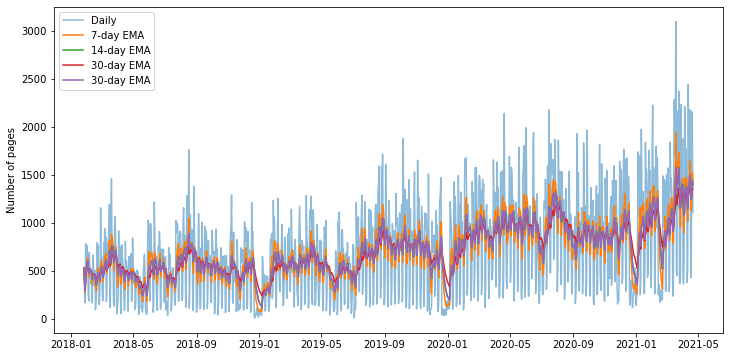

In [97]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages_count.index, pages_count, label='Daily', alpha=.5)

ax.plot(pages_count.index, ema_7d, label = '7-day EMA')
ax.plot(pages_count.index, ema_14d, label = '14-day EMA')
ax.plot(pages_count.index, ema_30d, label = '30-day EMA')
ax.plot(pages_count.index, ema_90d, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [99]:
# set the window span
span = 30

# compute midband
midband = pages_count.ewm(span=span).mean()

midband.head()

dt
2018-01-26    533.000000
2018-01-27    376.450000
2018-01-28    302.284709
2018-01-29    434.739290
2018-01-30    475.525441
Freq: D, Name: endpoint, dtype: float64

In [102]:
# compute exponential stdev
stdev = pages_count.ewm(span=span).std()

In [103]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

In [104]:
bb = pd.concat([ub, lb], axis=1)
bb.columns = ['ub', 'lb']

In [106]:
my_df = pd.concat([pages_count, midband, bb], axis=1)
my_df.columns = ['page_count', 'midband', 'ub', 'lb']

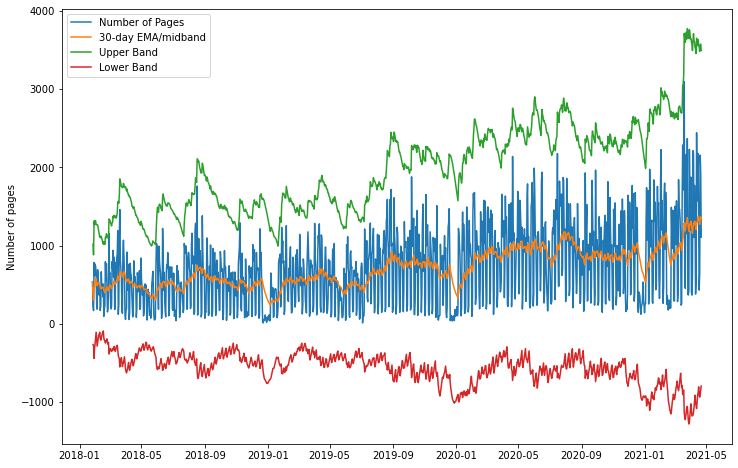

In [108]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.page_count, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [111]:
my_df['pct_b'] = (my_df['page_count'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
my_df

,page_count,midband,ub,lb,pct_b
dt,,,,,
2018-01-26,533,533.000000,NaN,NaN,NaN
2018-01-27,230,376.450000,1019.210064,-266.310064,0.386077
2018-01-28,168,302.284709,880.500977,-275.931559,0.383880
2018-01-29,783,434.739290,1312.207658,-442.729079,0.698446
2018-01-30,614,475.525441,1263.865971,-312.815089,0.587827
...,...,...,...,...,...
2021-04-17,430,1313.718776,3539.572262,-912.134710,0.301488
2021-04-18,651,1270.962726,3480.391221,-938.465770,0.359701
2021-04-19,2156,1328.061905,3565.644683,-909.520874,0.685007


In [191]:

def prep(df, user):
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.dt)
    df = df.set_index(df.dt)
    pages = df['endpoint'].resample('d').count()
    return pages


def compute_pct_b(pages, span, weight, user):
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df, user, span, weight):
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]

In [194]:
span = 30
weight = 3.5

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = my_df
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [213]:
anomalies.page_count.value_counts()


95      5466
1026    4555
106     4555
215     4555
77      4555
        ... 
527      911
526      911
1549     911
524      911
424      911
Name: page_count, Length: 831, dtype: int64

# 5.) At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before? all you have to worry about is looking at pages of cohort after 2019 and that will give you a good picture. If you know that then if those pages were 

the appendix for our curriculum is the same.

In [136]:
df_2019_prior = df[df.start_date < '01-01-2019']
df_2019_prior = df_2019_prior[df_2019_prior.endpoint != '/']
df_2019_after = df[df.start_date >= '01-01-2019']
df_2019_after = df_2019[df_2019.endpoint != '/']

In [143]:
df_2019_prior.endpoint.value_counts()

javascript-i                             6612
spring                                   5332
java-iii                                 5163
html-css                                 4782
java-ii                                  4711
                                         ... 
team-setups                                 1
html-css/introduction/:view-page            1
4-stats/2.2-probability_distributions       1
capstone/55                                 1
appendix/3d-plotting                        1
Name: endpoint, Length: 1857, dtype: int64

In [170]:
df_2019_over = pd.DataFrame(df_2019.groupby(['program_id']).endpoint.value_counts().sort_values(ascending = False)).rename(columns = {'endpoint':'count'}).reset_index()

In [171]:
df_2019_over

,program_id,endpoint,count
0,2,toc,13885
1,2,search/search_index.json,11786
2,2,javascript-i,11581
3,2,html-css,8329
4,2,java-iii,7999
...,...,...,...
1420,2,content/php_iii/php-with-html,1
1421,2,content/php_iii/include-and-require.html,1
1422,2,content/php_iii/classes-and-objects-i/gitbook/...,1
1423,2,content/php_iii/classes-and-objects-i,1


In [173]:
df_2019_over.groupby(['program_id'])['endpoint'].count()

program_id
2    744
3    681
Name: endpoint, dtype: int64

In [167]:
df_prior = pd.DataFrame(df_2019_prior.groupby(['program_id'])['endpoint'].value_counts().sort_values(ascending = False)).rename(columns = {'endpoint':'count'}).reset_index()

In [177]:
df_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2421 entries, 0 to 2420
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   program_id  2421 non-null   int64 
 1   endpoint    2421 non-null   object
 2   count       2421 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 56.9+ KB


In [183]:
df_2019_over[df_2019_over['count'] < 1000].head(50)

,program_id,endpoint,count
134,2,mysql/relationships,922
135,2,examples/css/media-queries.html,907
136,2,capstone,893
137,2,spring/fundamentals/integration-tests,862
138,3,anomaly-detection/AnomalyDetectionCartoon.jpeg,829
139,2,examples/javascript/defuse-the-bom.html,823
140,3,anomaly-detection/overview,804
141,3,10-anomaly-detection/AnomalyDetectionCartoon.jpeg,754
142,3,10-anomaly-detection/1-overview,751
143,2,examples/css/twitter.html,719


In [182]:
df_prior[df_prior['count'] < 1000].head(50)

,program_id,endpoint,count
94,2,java-iii/passwords,999
95,2,mysql/relationships/indexes,992
96,2,jquery/events/keyboard-events,970
97,2,html-css/css-i/introduction,954
98,2,javascript-i/objects/math,923
99,2,jquery/ajax,909
100,2,mysql/clauses/where,905
101,2,javascript-i/introduction,896
102,2,mysql/intellij,893
103,2,mysql/relationships/sub-queries,885


#### There is evidence of the fundamentals of data and classification being accesscced by webdevelopment students I can see clearly students with program id of 2 which is WD accessing fundamentals fatascience. While after 2019 only program_id of 3 accessed it.

# 6.) What topics are grads continuing to reference after graduation and into their jobs (for each program)?


if date after end date then bring up list of stuff they were looking at.

# 7.) Which lessons are least accessed?